In [32]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [111]:
# Load the data
data_path = "PJME_hourly.csv"
df = pd.read_csv(data_path)

# Convert 'Datetime' to datetime object and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Filter data from 2015 onwards
df = df['2015-01-01':]

# Remove duplicate timestamps
df = df[~df.index.duplicated(keep='first')]

# Resample to hourly frequency and forward-fill missing values
df = df.asfreq('H')
df = df.fillna(method='ffill')

In [ ]:

# Perform seasonal decomposition
decomposition = seasonal_decompose(df['PJME_MW'], model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['PJME_MW'], label='Original', alpha=0.5)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', alpha=0.5)
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', alpha=0.5)
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuals, label='Residuals', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
# Reset index and rename columns for Prophet
df = df.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})

# Display basic information about the data
print(f"{df.shape[0]} rows and {df.shape[1]} columns")
print(f"Min Date: {df['ds'].min()} AND Max Date: {df['ds'].max()}")

# Plot the data
plt.figure(figsize=(20, 10))
plt.plot(df['ds'], df['y'], lw=0.5)
plt.title("Hourly Energy Consumption")
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [43]:
# Define functions to identify seasons
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_fall(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month == 12) | (date.month <= 2)

# Apply seasonality functions
df['spring'] = df['ds'].apply(is_spring)
df['summer'] = df['ds'].apply(is_summer)
df['fall'] = df['ds'].apply(is_fall)
df['winter'] = df['ds'].apply(is_winter)

In [44]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size].copy()
test_data = df.iloc[train_size:].copy()

In [ ]:
### OPTIONAL: This Cell Searches For Optimal Parameters and is OPTIONAL
## WARNING: THIS CELL CAN TAKE DAYS TO RUN
## Note: I have ALREADY run the script and found strong parameters.

# Import necessary libraries for grid search
import itertools
import pickle
import os
import random

# Define parameter ranges for grid search
seasonality_modes = ['additive', 'multiplicative']
changepoint_prior_scale_values = np.linspace(0.0005, 0.005, 100)
seasonality_prior_scale_values = np.linspace(0.01, 10, 100)
holidays_prior_scale_values = np.linspace(0.01, 10, 100)
fourier_orders = [3, 5, 8, 10, 12, 15]

# Create a list of parameter combinations
param_grid = list(itertools.product(
    seasonality_modes,
    changepoint_prior_scale_values,
    seasonality_prior_scale_values,
    holidays_prior_scale_values,
    fourier_orders
))

# Randomly sample parameter combinations to limit computation time
random.seed(42)
num_samples = 7000  # Set the number of samples based on desired computation time
param_grid = random.sample(param_grid, min(num_samples, len(param_grid)))

# Function to save progress
def save_progress(progress_data):
    with open('prophet_grid_search_progress.pkl', 'wb') as f:
        pickle.dump(progress_data, f)
    print("Progress saved!")

# Function to load progress
def load_progress():
    if os.path.exists('prophet_grid_search_progress.pkl'):
        with open('prophet_grid_search_progress.pkl', 'rb') as f:
            progress_data = pickle.load(f)
        print("Progress loaded!")
        return progress_data
    else:
        return None

# Function to evaluate a single parameter combination
def evaluate_params(params, idx):
    seasonality_mode = params[0]
    changepoint_prior_scale = params[1]
    seasonality_prior_scale = params[2]
    holidays_prior_scale = params[3]
    fourier_order = params[4]

    print(f"Evaluating combination {idx+1}/{len(param_grid)}:")
    print(f"seasonality_mode={seasonality_mode}, "
          f"changepoint_prior_scale={changepoint_prior_scale}, "
          f"seasonality_prior_scale={seasonality_prior_scale}, "
          f"holidays_prior_scale={holidays_prior_scale}, "
          f"fourier_order={fourier_order}")

    try:
        # Initialize the Prophet model with current parameters
        m_train = Prophet(
            seasonality_mode=seasonality_mode,
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )

        # Add country holidays
        m_train.add_country_holidays(country_name='US')

        # Add seasonality components with current fourier_order
        m_train.add_seasonality(name='spring', period=91.25, fourier_order=fourier_order, condition_name='spring')
        m_train.add_seasonality(name='summer', period=92.5, fourier_order=fourier_order, condition_name='summer')
        m_train.add_seasonality(name='fall', period=91.25, fourier_order=fourier_order, condition_name='fall')
        m_train.add_seasonality(name='winter', period=90, fourier_order=fourier_order, condition_name='winter')

        # Fit the model on training data
        m_train.fit(train_data)

        # Create future dataframe for test period
        future_test = m_train.make_future_dataframe(periods=len(test_data), freq='H')
        future_test['spring'] = future_test['ds'].apply(is_spring)
        future_test['summer'] = future_test['ds'].apply(is_summer)
        future_test['fall'] = future_test['ds'].apply(is_fall)
        future_test['winter'] = future_test['ds'].apply(is_winter)

        # Predict on test data
        forecast_test = m_train.predict(future_test)

        # Extract the predictions corresponding to the test set
        forecast_test = forecast_test.iloc[-len(test_data):]

        # Calculate MAPE
        mape = mean_absolute_percentage_error(test_data['y'], forecast_test['yhat']) * 100
        print(f'MAPE on Test Set: {mape:.2f}%')

        # Return the result
        result = {
            'params': {
                'seasonality_mode': seasonality_mode,
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale,
                'holidays_prior_scale': holidays_prior_scale,
                'fourier_order': fourier_order
            },
            'mape': mape
        }
        return result

    except Exception as e:
        print(f"Error with combination {idx+1}: {e}")
        return None

# Load progress if available
progress = load_progress()
if progress:
    start_index = progress['last_index']
    best_mape = progress['best_mape']
    best_params = progress['best_params']
    results = progress['results']
    evaluated_indices = progress['evaluated_indices']
    print(f"Resuming grid search from index {start_index}")
else:
    start_index = 0
    best_mape = np.inf
    best_params = None
    results = []
    evaluated_indices = set()
    print("Starting new grid search")

# Evaluate parameter combinations sequentially
total_combinations = len(param_grid)

for idx in range(start_index, total_combinations):
    params = param_grid[idx]
    if idx in evaluated_indices:
        continue  # Skip already evaluated combinations

    res = evaluate_params(params, idx)
    if res is not None:
        evaluated_indices.add(idx)
        results.append(res)
        mape = res['mape']

        # Update best parameters if current MAPE is lower
        if mape < best_mape:
            best_mape = mape
            best_params = res['params']
            print("New best parameters found!")
            print(f"Best MAPE: {best_mape:.2f}%")
            print(f"Best Parameters: {best_params}")

        # Save progress after each iteration
        progress_data = {
            'last_index': idx + 1,
            'best_mape': best_mape,
            'best_params': best_params,
            'results': results,
            'evaluated_indices': evaluated_indices
        }
        save_progress(progress_data)

print("\nGrid search completed.")
print(f"Best MAPE: {best_mape:.2f}%")
print(f"Best Parameters: {best_params}")

In [104]:
# Initialize the Prophet model with the best parameters found in the grid search
best_params = {
    'seasonality_mode': 'additive',
    'changepoint_prior_scale': 0.014,
    'seasonality_prior_scale': 0.01,
    'holidays_prior_scale': 3.13,
    'fourier_order': 3
}

In [105]:
m = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'] + 0.003,
    seasonality_prior_scale=best_params['seasonality_prior_scale']+0.05,
    holidays_prior_scale=best_params['holidays_prior_scale'],
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)

# Add US holidays
m.add_country_holidays(country_name='US')

# Add seasonalities for seasons
fourier_order = best_params['fourier_order']
m.add_seasonality(name='spring', period=91.25, fourier_order=fourier_order, condition_name='spring')
m.add_seasonality(name='summer', period=92.5, fourier_order=fourier_order, condition_name='summer')
m.add_seasonality(name='fall', period=91.25, fourier_order=fourier_order, condition_name='fall')
m.add_seasonality(name='winter', period=90, fourier_order=fourier_order, condition_name='winter')

# Fit the model on training data
m.fit(train_data)

19:24:15 - cmdstanpy - INFO - Chain [1] start processing
19:24:20 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
# Create future dataframe for the test period
future = m.make_future_dataframe(periods=len(test_data), freq='H')
future['spring'] = future['ds'].apply(is_spring)
future['summer'] = future['ds'].apply(is_summer)
future['fall'] = future['ds'].apply(is_fall)
future['winter'] = future['ds'].apply(is_winter)

In [107]:
# Predict on test data
forecast = m.predict(future)

# Extract the predictions corresponding to the test set
forecast_test = forecast.iloc[-len(test_data):]

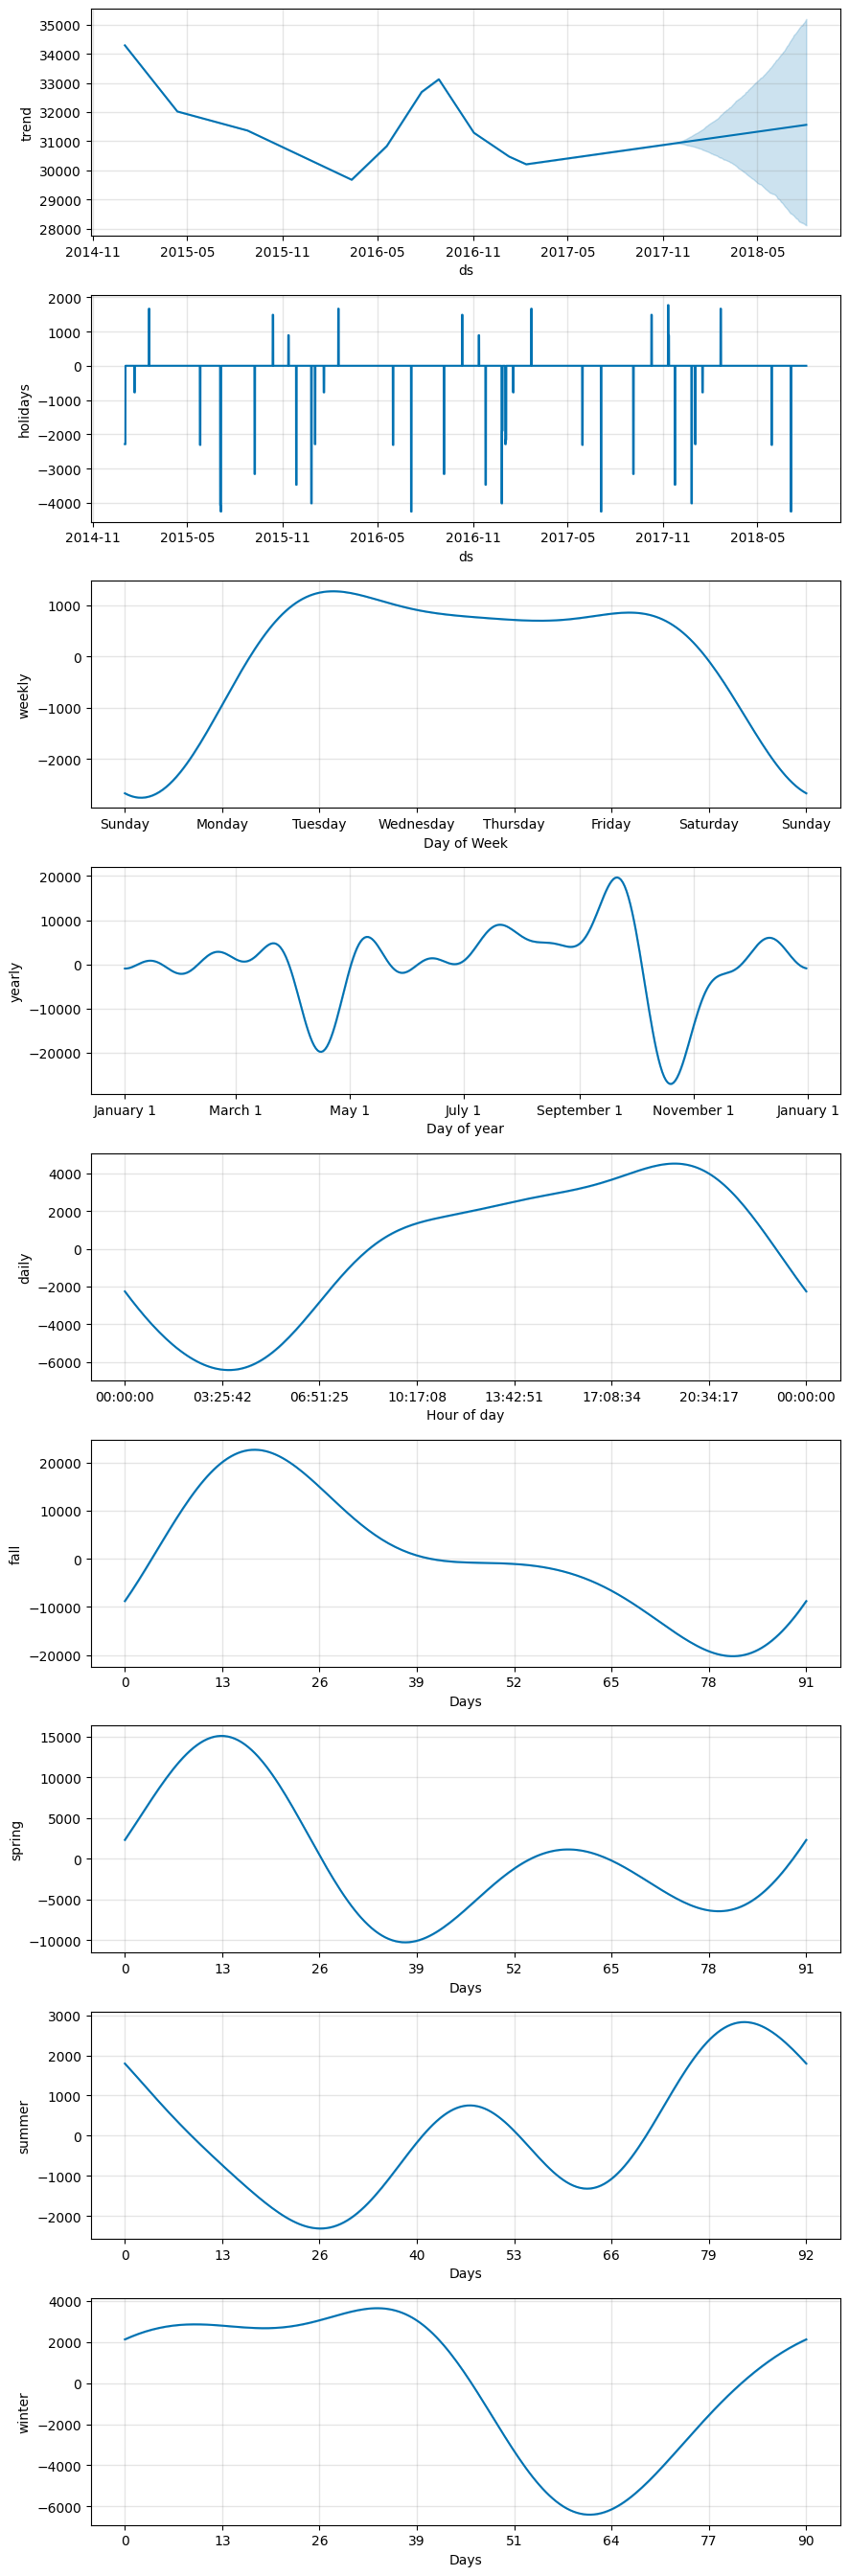

In [108]:
# Plot forecast components
m.plot_components(forecast)
plt.show()

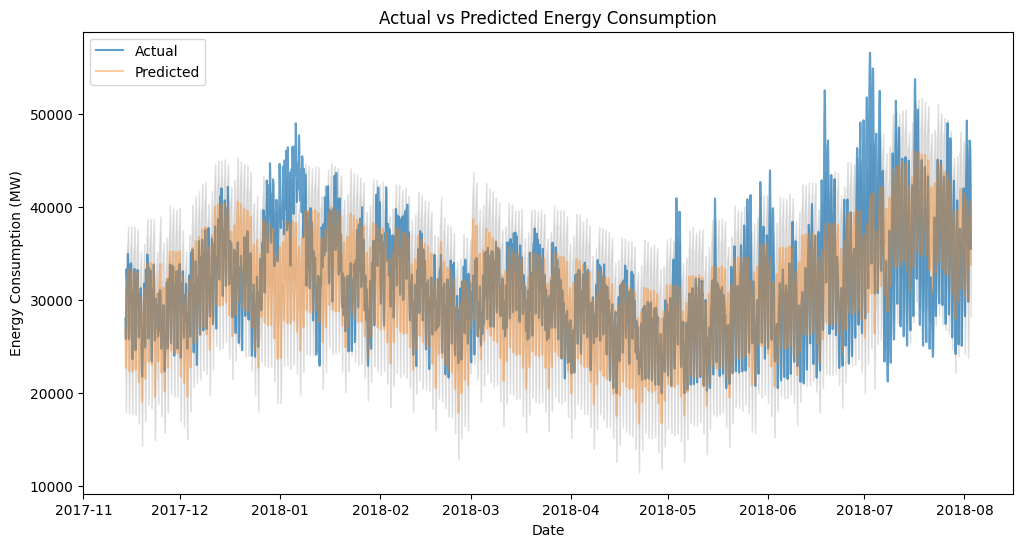

MAPE on Test Set: 9.68%


In [109]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', alpha=0.7)
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Predicted', alpha=0.4)
plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    color='gray',
    alpha=0.2
)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()

# Calculate MAPE
mape = mean_absolute_percentage_error(test_data['y'], forecast_test['yhat']) * 100
print(f'MAPE on Test Set: {mape:.2f}%')